In [2]:
#Importing all the libraries needed.
import pandas as pd
import numpy as np
import librosa
from sklearn.utils import shuffle
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,LSTM,TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import dask.array as da
import matplotlib.pyplot as plt
import warnings
import h5py
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [21]:
#Building the CNN-LSTM model.
model=Sequential()
model.add(TimeDistributed(Conv2D(12, (3,3),activation='relu'),input_shape=(1,513, 87, 1)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.3)))
model.add(TimeDistributed(Conv2D(32, (3,3),activation='relu'),input_shape=(1,513, 87, 1)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(6))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [4]:
#Opening all the hdf5 dumps created.


train1_x=h5py.File('./X_data.hdf5','r')
train1_y=h5py.File('./Y_data.hdf5','r')
train2_x=h5py.File('./X_data2.hdf5','r')
train2_y=h5py.File('./Y_data2.hdf5','r')
train3_x=h5py.File('./X_data3.hdf5','r')
train3_y=h5py.File('./Y_data3.hdf5','r')
train4_x=h5py.File('./X_data4.hdf5','r')
train4_y=h5py.File('./Y_data4.hdf5','r')

val1_x=h5py.File('./X_val1.hdf5')
val1_y=h5py.File('./Y_val1.hdf5')


In [3]:
#Building the batch generator.
def batch_generator_val(batch_size):
    while True:
        data=[]
        label=[]

        random_idxs=np.random.randint(0,len(val1_x['results']),batch_size)
        for idx in random_idxs:
            dt_x=np.array(val1_x['results'][idx])
            dt_y=np.array(val1_y['results'][idx])
            data.append(dt_x)
            label.append(dt_y)
        yield np.array(data),np.array(label)
        
     

def batch_generator_train(batch_size):
    while True:
        data=[]
        label=[]
        
        rdm=np.random.randint(0,4)
        if rdm==0:
            random_idxs=np.random.randint(0,len(train1_x['results']),batch_size)
            for idx in random_idxs:
                dt_x=np.array(train1_x['results'][idx])
                dt_y=np.array(train1_y['results'][idx])
                data.append(dt_x)
                label.append(dt_y)
        elif rdm==1:
            random_idxs=np.random.randint(0,len(train3_x['results']),batch_size)
            for idx in random_idxs:
                dt_x=np.array(train3_x['results'][idx])
                dt_y=np.array(train3_y['results'][idx])
                data.append(dt_x)
                label.append(dt_y)
        elif rdm==2:
            random_idxs=np.random.randint(0,len(train4_x['results']),batch_size)
            for idx in random_idxs:
                dt_x=np.array(train4_x['results'][idx])
                dt_y=np.array(train4_y['results'][idx])
                data.append(dt_x)
                label.append(dt_y)
        else:
            random_idxs=np.random.randint(0,len(train2_x['results']),batch_size)
            for idx in random_idxs:
                dt_x=np.array(train2_x['results'][idx])
                dt_y=np.array(train2_y['results'][idx])
                data.append(dt_x)
                label.append(dt_y)
            
        yield np.array(data),np.array(label)
        
        


In [22]:
#Trains the model.

batch_size=32
#train_steps=(len(train1_x['results'])+len(train2_x['results'])+len(train3_x['results'])+len(train4_x['results']))//batch_size
train_steps=2000
validation_steps=len(val1_x['results'])//batch_size
history=model.fit_generator(batch_generator_train(32),steps_per_epoch=train_steps,validation_data=batch_generator_val(32),
                    validation_steps=validation_steps,epochs=12,shuffle=True)

Epoch 1/12
2000/2000 [==============================] - 1116s 558ms/step - loss: 0.5855 - acc: 0.6883 - val_loss: 0.4698 - val_acc: 0.8211
Epoch 2/12
2000/2000 [==============================] - 1035s 517ms/step - loss: 0.5479 - acc: 0.7231 - val_loss: 0.4801 - val_acc: 0.8277
Epoch 3/12
2000/2000 [==============================] - 1089s 545ms/step - loss: 0.5398 - acc: 0.7295 - val_loss: 0.4616 - val_acc: 0.8251
Epoch 4/12
2000/2000 [==============================] - 1128s 564ms/step - loss: 0.5327 - acc: 0.7321 - val_loss: 0.4828 - val_acc: 0.7965
Epoch 5/12
2000/2000 [==============================] - 1068s 534ms/step - loss: 0.5365 - acc: 0.7298 - val_loss: 0.4513 - val_acc: 0.8331
Epoch 6/12
2000/2000 [==============================] - 1290s 645ms/step - loss: 0.5305 - acc: 0.7366 - val_loss: 0.4416 - val_acc: 0.8353
Epoch 7/12
2000/2000 [==============================] - 1179s 589ms/step - loss: 0.5339 - acc: 0.7352 - val_loss: 0.4558 - val_acc: 0.8238
Epoch 8/12
2000/2000 [=====

Text(0.5, 0, 'Epoch')

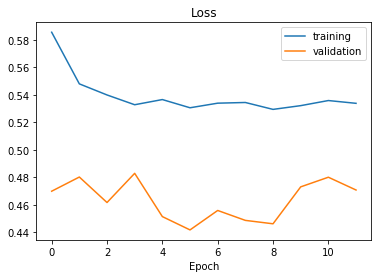

In [25]:
#Visualising the train and validation loss.
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [26]:
#Saving the model.
model.save('HVDv1.h5')